In [28]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os

In [29]:
statedict = {'PA':'Pennsylvania', 'CT':'Connecticut', 'MA':'Massachusetts', 'NH':'New Hampshire', 'DE':'Delaware',
             'NC':'North Carolina', 'GA':'Georgia', 'NY':'New York', 'NJ': 'New Jersey', 'RI':'Rhode Island',
             'VA':'Virginia', 'MD':'Maryland', 'SC':'South Carolina', 'VT':'Vermont'}

## Geography Table

In [30]:
CD_table = pd.read_csv('../Results/CD_table.csv', index_col = 0)
CD_table.loc[CD_table[CD_table['Location'].apply(lambda x: len(x.split(", "))==4)].index, 'Location'] = ['New York City West Ward, New York, New York']
CD_table['Occupations'] = CD_table['Occupations'].apply(lambda x: x.replace('\'','').replace('\"','').strip('][').split(', '))

In [31]:
def processLocation(loc):
    if len(loc) == 1:
        if loc[0] == 'United States':
            return [np.nan, np.nan, np.nan, 'United States']
        elif loc[0].strip() not in list(statedict.values()):
            return [np.nan, np.nan, np.nan, loc[0]]
        else:
            return [np.nan, np.nan, loc[0], 'United States']
    elif len(loc) == 2:
        if loc[1].strip() not in list(statedict.values()):
            return [np.nan, np.nan, loc[0], loc[1]]
        else:
            return [np.nan, loc[0], loc[1], 'United States']
    else:
        return [loc[0], loc[1], loc[2], 'United States']

In [32]:
CD_table[['town', 'county', 'state', 'country']] = CD_table['Location'].apply(lambda x: processLocation(x.split(", "))).values.tolist()
CD_table['state'] = CD_table['state'].apply(lambda x: x.strip() if not pd.isnull(x) else x)
CD_table['town'] = CD_table['town'].apply(lambda x: x.strip() if not pd.isnull(x) else x)
CD_table['county'] = CD_table['county'].apply(lambda x: x.strip() if not pd.isnull(x) else x)
CD_table['country'] = CD_table['country'].apply(lambda x: x.strip() if not pd.isnull(x) else x)

In [33]:
tb = CD_table[['Location','Search Names', '6p_Total', '6p_def_Total', '3p_Total', 'count', 'town', 'county', 'state', 'country']]
tb['Search Names'] = tb['Search Names'].apply(lambda x: x.replace('\'','').replace('\"','').strip('][').split(', '))
tb[['town', 'county', 'state','country']] = tb[['town', 'county', 'state','country']].fillna('')
tb_final = tb.groupby(['town', 'county', 'state','country'])['6p_Total', '6p_def_Total', '3p_Total', 'count'].sum().reset_index()

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_82626/4258588098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb['Search Names'] = tb['Search Names'].apply(lambda x: x.replace('\'','').replace('\"','').strip('][').split(', '))
/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_82626/4258588098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb[['town', 'county', 'state','country']] = tb[['town', 'county', 'state','country']].fillna('')
/var/folders/5s/dvrxt95949x1pm_sjxm85lj000

In [34]:
count_tb = tb[['town', 'county', 'state','country', 'Search Names']].explode('Search Names').drop_duplicates().groupby(['town', 'county', 'state','country'])['Search Names'].count().reset_index()
count_tb.rename({'Search Names':'# Debtholders'}, axis = 1, inplace = True)

In [35]:
tb_merged = pd.merge(tb_final, count_tb)
tb_merged.rename({'count':'Certificate Count'}, axis = 1, inplace = True)
#tb_merged = tb_merged.replace('', np.nan)

In [36]:
tb_merged['town/county pct (6p)'] = np.round(tb_merged['6p_Total'] /
                                             tb_merged.groupby(['state', 'county'])['6p_Total'].transform('sum')*100, 2)
tb_merged['county/state pct (6p)'] = np.round(tb_merged.groupby(['state', 'county'])['6p_Total'].transform('sum') /
                                         tb_merged.groupby('state')['6p_Total'].transform('sum')*100, 2)
tb_merged['state/country pct (6p)'] = np.round(tb_merged.groupby(['state', 'country'])['6p_Total'].transform('sum') /
                                          tb_merged.groupby('country')['6p_Total'].transform('sum')*100, 2)
tb_merged['country/ovall pct (6p)'] = np.round(tb_merged.groupby('country')['6p_Total'].transform('sum') /
                                          tb_merged['6p_Total'].sum()*100, 2)
tb_merged['6p_Total'] = tb_merged['6p_Total'].apply(lambda x: round(x, 2))
tb_merged['6p_def_Total'] = tb_merged['6p_def_Total'].apply(lambda x: round(x, 2))
tb_merged['3p_Total'] = tb_merged['3p_Total'].apply(lambda x: round(x, 2))

In [37]:
tb_merged

,town,county,state,country,6p_Total,6p_def_Total,3p_Total,Certificate Count,# Debtholders,town/county pct (6p),county/state pct (6p),state/country pct (6p),country/ovall pct (6p)
0,,,,Bermuda,847.0,424.0,478.0,2,2,70.47,100.00,100.00,0.01
1,,,,Great Britain,244.0,122.0,270.0,1,1,20.30,100.00,100.00,0.00
2,,,,United States,111.0,105.0,73.0,1,1,9.23,100.00,0.00,99.96
3,,,Bourdeaux,France,71.0,85.0,0.0,1,1,100.00,100.00,100.00,0.00
4,,,Connecticut,United States,414557.0,207478.0,132330.0,30,31,100.00,43.78,13.02,99.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,Yonkers,Westchester,New York,United States,0.0,0.0,2456.0,1,1,0.00,0.24,17.81,99.96
538,York,Westchester,New York,United States,285.0,192.0,211.0,1,2,9.36,0.24,17.81,99.96
539,York,York,Maine,United States,247.0,173.0,57.0,1,1,100.00,100.00,0.00,99.96
540,York,York,Pennsylvania,United States,1461.0,880.0,410.0,6,7,8.92,0.85,26.56,99.96


In [38]:
tb_merged.sort_values(['country', 'state', 'county', 'town'], ascending = [False, True, True, True]).to_csv('../Results/geography_table.csv')

## Occupation Table

In [39]:
#basic preprocessing
occ_table = CD_table[['state', 'county', 'Occupations', '6p_Total', '6p_def_Total', '3p_Total']]
occ_table['Occ_str'] = occ_table['Occupations'].astype(str)
occ_table['Occ_str'] = occ_table['Occ_str'].apply(lambda x: x.replace("[\'","").replace("\']","").replace("\'",""))
occ_table['count'] = 1

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_82626/2855494518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ_table['Occ_str'] = occ_table['Occupations'].astype(str)
/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_82626/2855494518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ_table['Occ_str'] = occ_table['Occ_str'].apply(lambda x: x.replace("[\'","").replace("\']","").replace("\'",""))
/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_82626/2855494518.py:5

In [40]:
occ_table_grouped = occ_table.groupby(['Occ_str']).agg({'6p_Total':sum, '6p_def_Total':sum, '3p_Total':sum,
                                                        'count':sum}).reset_index()
occ_table_grouped.columns = ['Occupations', '6p_Total', '6p_def_Total', '3p_Total', 'count']
occ_table_grouped['Average (6p)'] = occ_table_grouped['6p_Total']/occ_table_grouped['count']
for col in ['6p_Total', '6p_def_Total', '3p_Total', 'count']:
    occ_table_grouped[col+"_pct"] = occ_table_grouped[col]/occ_table_grouped[col].sum()*100

In [41]:
occ_table_grouped.sort_values('6p_Total', ascending = False).to_csv('../Results/Occupation_table.csv')

### Make for each state

In [42]:
for state_fn in statedict.values():
    occ_table_grouped = occ_table[occ_table['state'] == state_fn].groupby(['Occ_str']).agg({'6p_Total': sum, '6p_def_Total': sum,
                                                                                         '3p_Total': sum,'count': sum}).reset_index()
    occ_table_grouped.columns = ['Occupations', '6p_Total', '6p_def_Total', '3p_Total', 'count']
    occ_table_grouped['state'] = state_fn

    occ_table_grouped['Average (6p)'] = occ_table_grouped['6p_Total'] / occ_table_grouped['count']
    for col in ['6p_Total', '6p_def_Total', '3p_Total', 'count']:
        occ_table_grouped[col + "_pct"] = occ_table_grouped[col] / occ_table_grouped[col].sum() * 100
    for col in occ_table_grouped.columns[1:]:
        if col != 'state':
            occ_table_grouped[col] = occ_table_grouped[col].apply(lambda x: round(x, 2))
    occ_table_grouped.sort_values('6p_Total', ascending = False).to_csv(f'../Results/Occupation_states/{state_fn.replace(" ", "_")}_Occupation_table.csv')

## Maps

In [43]:
# make maps folder
for dirs in ['maps', 'maps/statemaps', 'maps/allstates']:
    try:
        os.mkdir("../Results/"+dirs)
    except:
        print("{} folder already exists".format(dirs))

maps folder already exists
maps/statemaps folder already exists
maps/allstates folder already exists


In [44]:
# import map shapefile
map_df = gpd.read_file("../../Data/StateShapeFiles/historicalcounties")

map_df.rename(columns = {'NHGISNAM':'county'}, inplace = True)
map_df.rename(columns = {'STATENAM':'state'}, inplace = True)

map_df.head()

,ID,ID2,OBJECTID,GISJOIN,DECADE,county,NHGISST,NHGISCTY,ICPSRST,ICPSRCTY,ICPSRNAM,state,SHAPE_AREA,SHAPE_LEN,AreaI,Geo_FIPS,geometry
0,11643,59420,1,0900010,1790,Fairfield,090,0010,1,10,FAIRFIELD,Connecticut,1.673889e+09,411293.875529,1.673889e+09,0900010,"MULTIPOLYGON (((-73.71277 41.10770, -73.71157 ..."
1,11644,59421,2,0900030,1790,Hartford,090,0030,1,30,HARTFORD,Connecticut,1.858418e+09,197092.380518,1.858419e+09,0900030,"POLYGON ((-72.99955 41.80002, -72.99752 41.800..."
2,11645,59422,3,0900050,1790,Litchfield,090,0050,1,50,LITCHFIELD,Connecticut,2.656161e+09,236932.296583,2.656167e+09,0900050,"POLYGON ((-73.51778 41.67084, -73.51776 41.671..."
3,11646,59423,165,0900070,1790,Middlesex,090,0070,1,70,MIDDLESEX,Connecticut,9.325004e+08,199607.085852,9.325065e+08,0900070,"MULTIPOLYGON (((-72.74954 41.59314, -72.74564 ..."
4,11647,59424,4,0900090,1790,New Haven,090,0090,1,90,NEW HAVEN,Connecticut,1.528738e+09,312354.008005,1.528726e+09,0900090,"MULTIPOLYGON (((-73.16029 41.43809, -73.16055 ..."


In [45]:
county_count_tb = tb[['county', 'state','country', 'Search Names']].explode('Search Names').drop_duplicates().groupby(['county', 'state','country'])['Search Names'].count().reset_index()
county_count_tb.rename({'Search Names':'# Debtholders'}, axis = 1, inplace = True)

In [46]:
# debt file
map_table = CD_table[['county', 'state', '6p_Total']].fillna('')
map_table_grouped = map_table.groupby(['county', 'state']).sum('6p_Total').reset_index()
map_table_grouped = map_table_grouped[map_table_grouped['state'].apply(lambda x: x in statedict.values())]
map_table_grouped = map_table_grouped[map_table_grouped['county'] != ""]
map_table_grouped['county'] = map_table_grouped['county'].apply(lambda x: 'Prince Georges' if x == 'Prince George\'s' else x)
map_table_grouped['county'] = map_table_grouped['county'].apply(lambda x: 'Queen Annes' if x == 'Queen Anne\'s' else x)
map_table_grouped = pd.merge(map_table_grouped, county_count_tb)
map_table_grouped['6p_Total_avg'] = map_table_grouped['6p_Total']/map_table_grouped['# Debtholders']
"""countyPop = pd.read_csv('../../Data/CensusData/countyPopulation.csv').drop(0).reset_index(drop = True)
sub_cols =['Area Name', 'State/US Abbreviation', 'Total Population', 'White Male', 'White Male Age 16 Years and over']
county_subset = countyPop[sub_cols]
merged_geography = pd.merge(county_subset, grouped_assets, left_on = ['Area Name', 'State/US Abbreviation'], right_on=['county', 'state'], how = 'right')
final_asset_data = merged_geography.drop(['Area Name', 'State/US Abbreviation'], axis = 1)
final_asset_data['debt_per_capita'] = final_asset_data['6p_total']/final_asset_data['Total Population'].apply(lambda x: float(x))
final_asset_data['debt_per_white_male'] = final_asset_data['6p_total']/final_asset_data['White Male'].apply(lambda x: float(x))"""

"countyPop = pd.read_csv('../../Data/CensusData/countyPopulation.csv').drop(0).reset_index(drop = True)\nsub_cols =['Area Name', 'State/US Abbreviation', 'Total Population', 'White Male', 'White Male Age 16 Years and over']\ncounty_subset = countyPop[sub_cols]\nmerged_geography = pd.merge(county_subset, grouped_assets, left_on = ['Area Name', 'State/US Abbreviation'], right_on=['county', 'state'], how = 'right')\nfinal_asset_data = merged_geography.drop(['Area Name', 'State/US Abbreviation'], axis = 1)\nfinal_asset_data['debt_per_capita'] = final_asset_data['6p_total']/final_asset_data['Total Population'].apply(lambda x: float(x))\nfinal_asset_data['debt_per_white_male'] = final_asset_data['6p_total']/final_asset_data['White Male'].apply(lambda x: float(x))"

In [47]:
#merge data and map data
merged = pd.merge(map_df, map_table_grouped, on=['county', 'state'], how='left')
merged['6p_Total'] = merged['6p_Total'].fillna(0)

In [48]:
def plotState(merged, state, variable = '6p_Total'):
    if state not in statedict.values():
        print("{} is not a valid state".format(state))
        return
    fig, ax = plt.subplots(1, figsize=(20, 12))
    ax.axis('off')

    # get data for particular state
    state_df = merged[merged['state'] == state]
    #state_df[variable] = state_df[variable].apply(lambda x: np.log10(x+1))
    state_max = state_df[variable].max()
    state_df[state_df['state'] == state].apply(lambda merged: ax.annotate(text=merged['county'], fontsize = 7, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)

    # colorbar
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=state_max))
    sm._A = []
    cbar = fig.colorbar(sm)
    if variable == "6p_Total":
        label = '(base 10) 6% Debt Coupon Stock ($)'
    if variable == "6p_Total_avg":
        label = 'Mean 6% Debt Coupon Stock ($ per Debtholder)'
    if variable == "debt_per_capita":
        label = '6% Debt per Capita Coupon Stock ($ per Individual)'
    if variable == "debt_per_white_male":
        label = '6% Debt per White Male Coupon Stock ($ per White Male)'
    cbar.set_label(label)
    # colormap
    cmap = plt.get_cmap('YlOrRd').copy()
    cmap.set_under('white')

    state_df[state_df['state'] == state].plot(column=variable, cmap= cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=0, vmax = state_max)
    ax.set_title("Map of Continental Debt {} Across Counties in {}".format(label, state))
    for dirs in ['maps/statemaps/'+variable]:
        try:
            os.mkdir("../Results/"+dirs)
        except:
            pass

    fig.savefig('../Results/{}/{}_{}_map.png'.format(dirs,state, variable), dpi = 200)

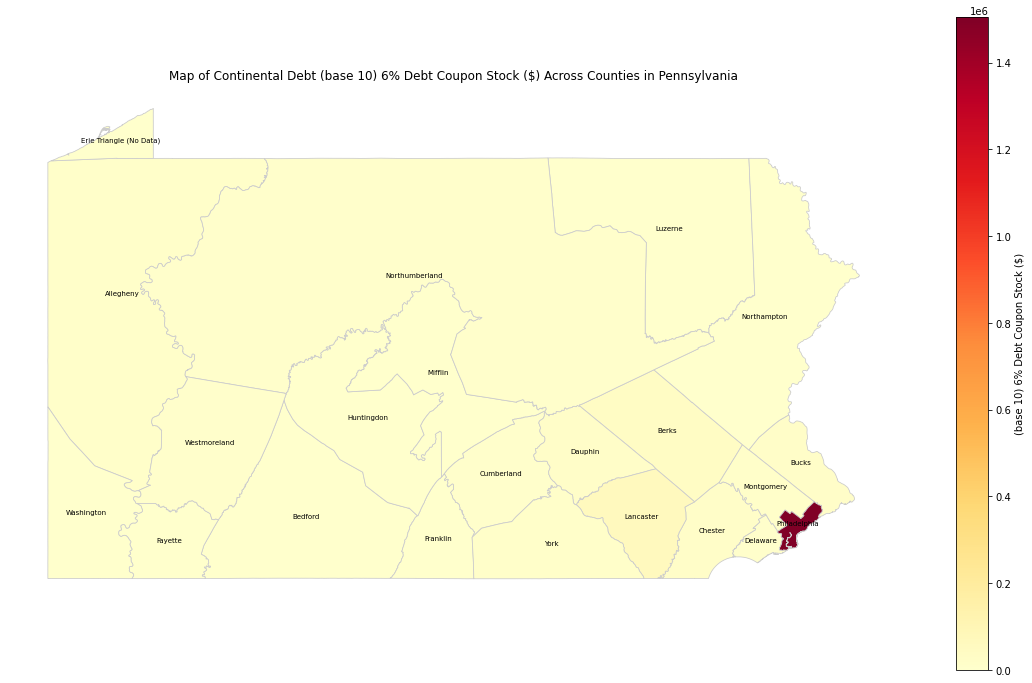

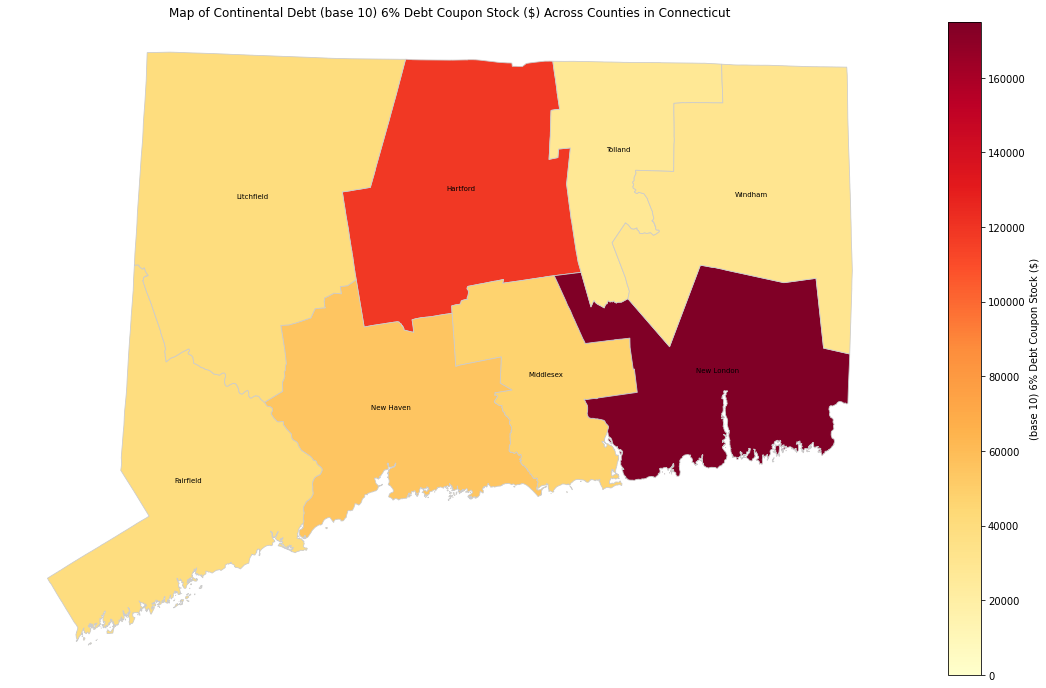

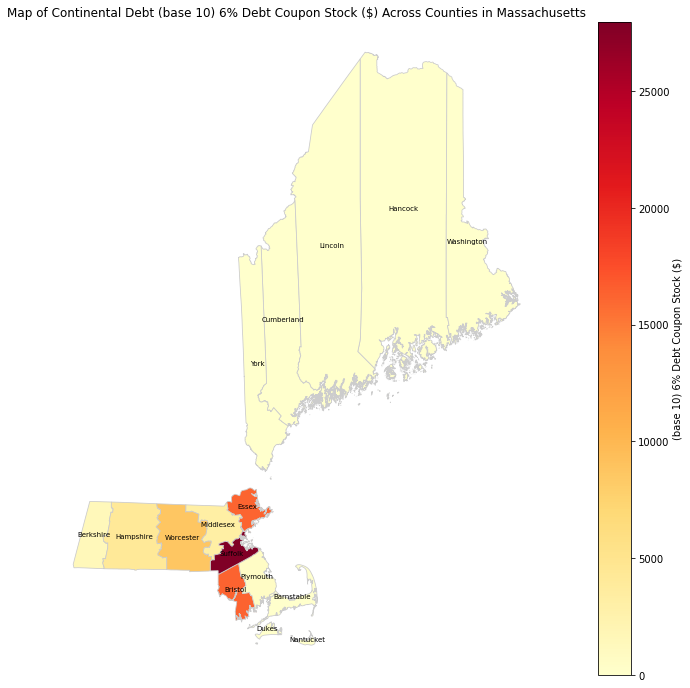

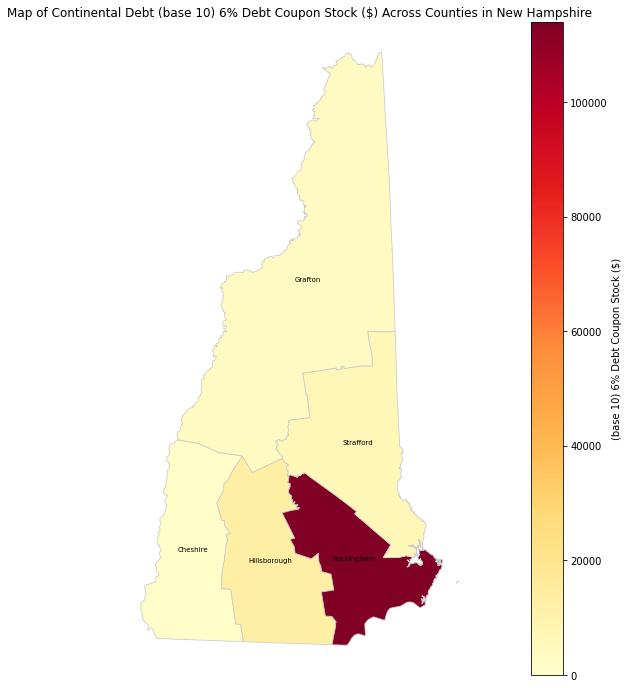

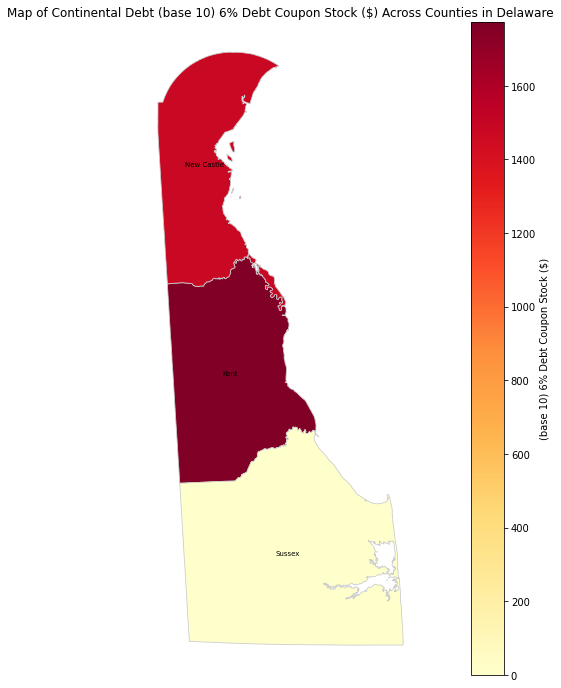

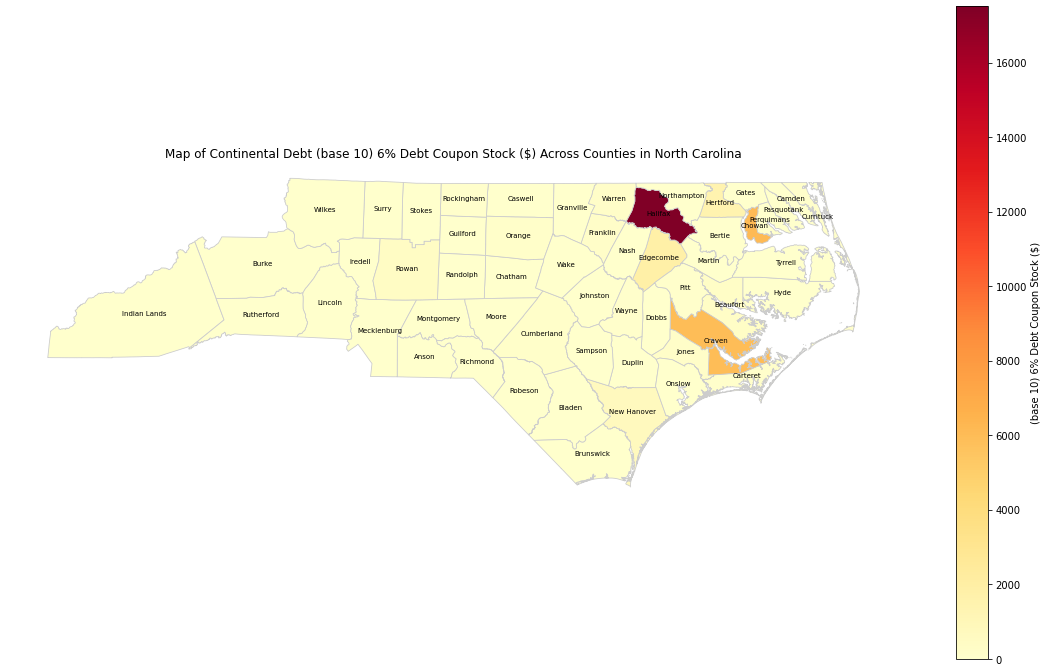

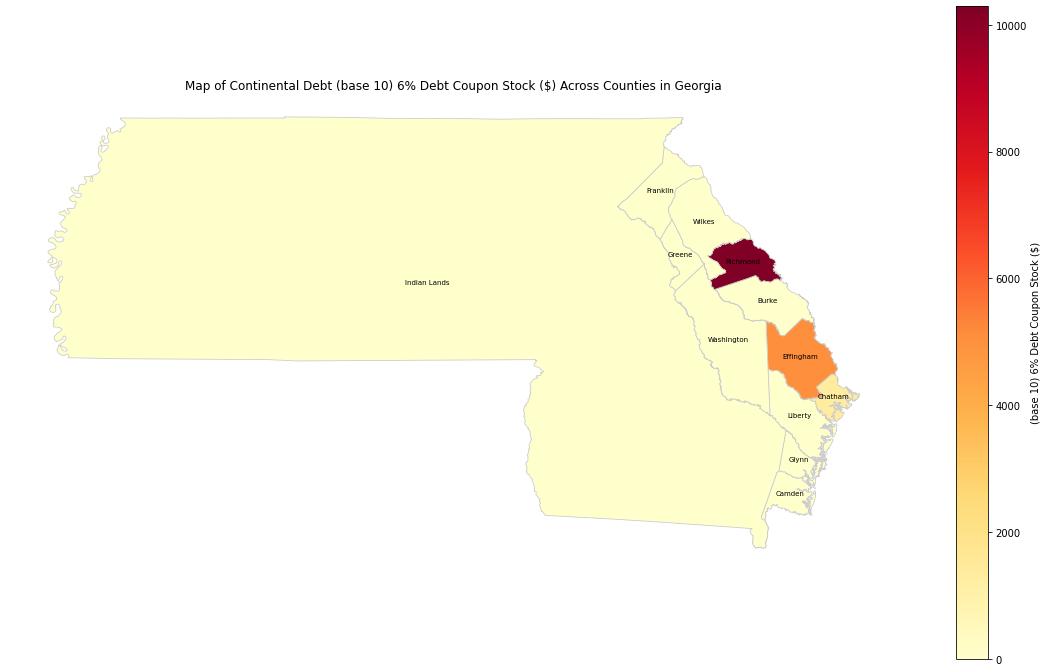

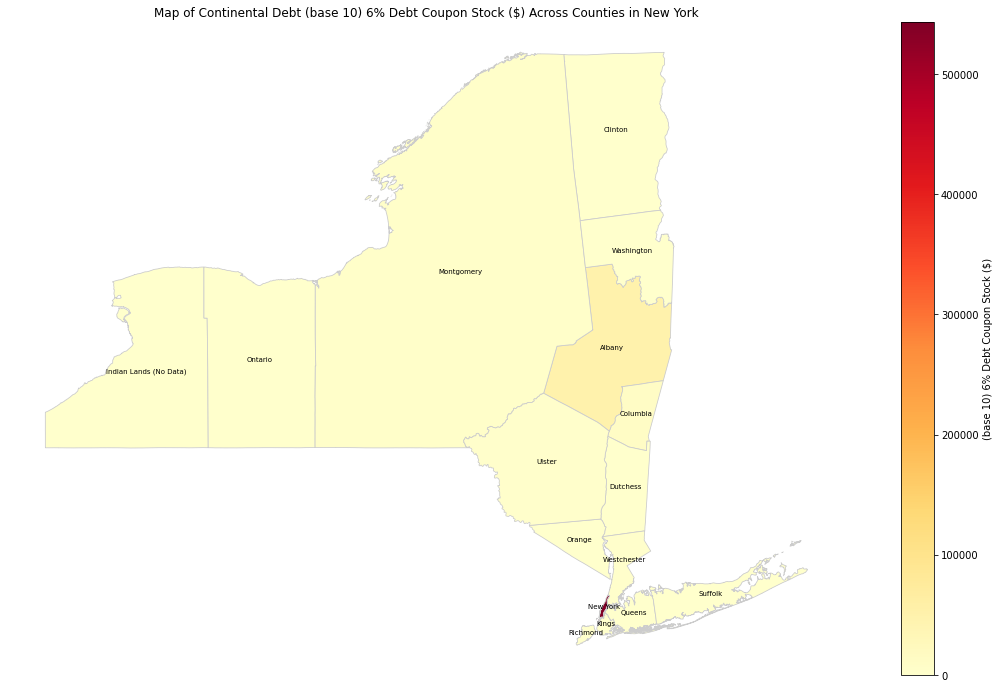

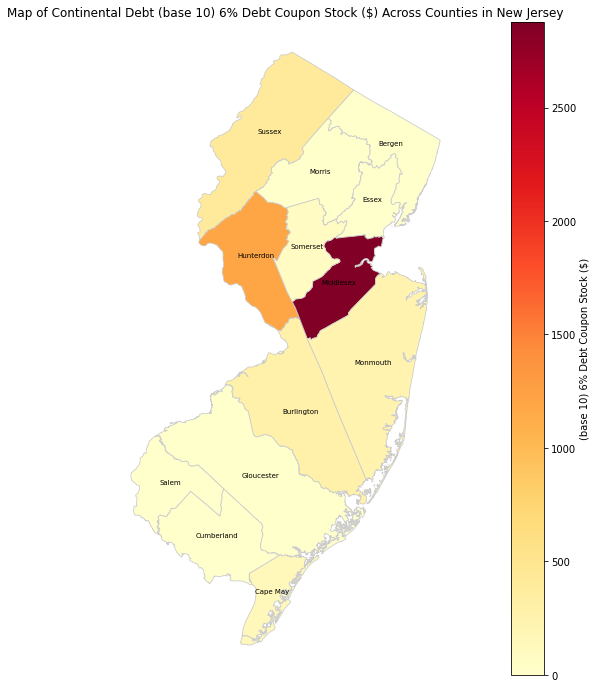

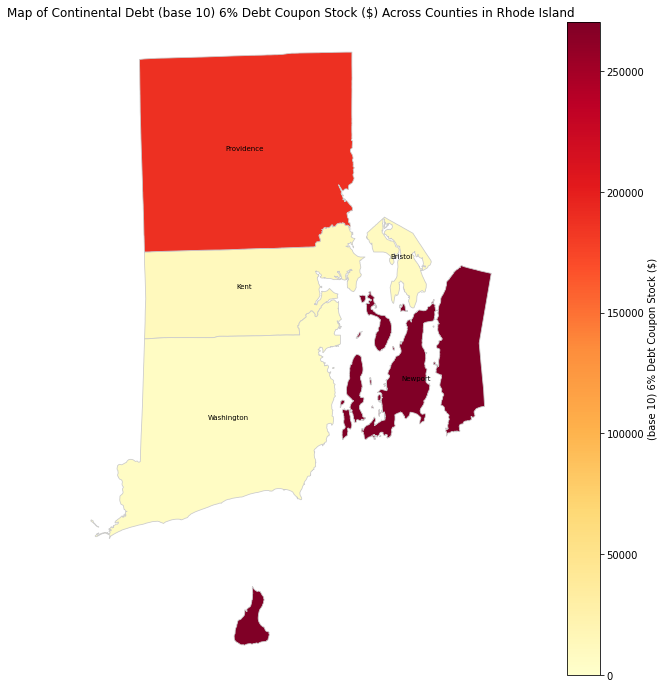

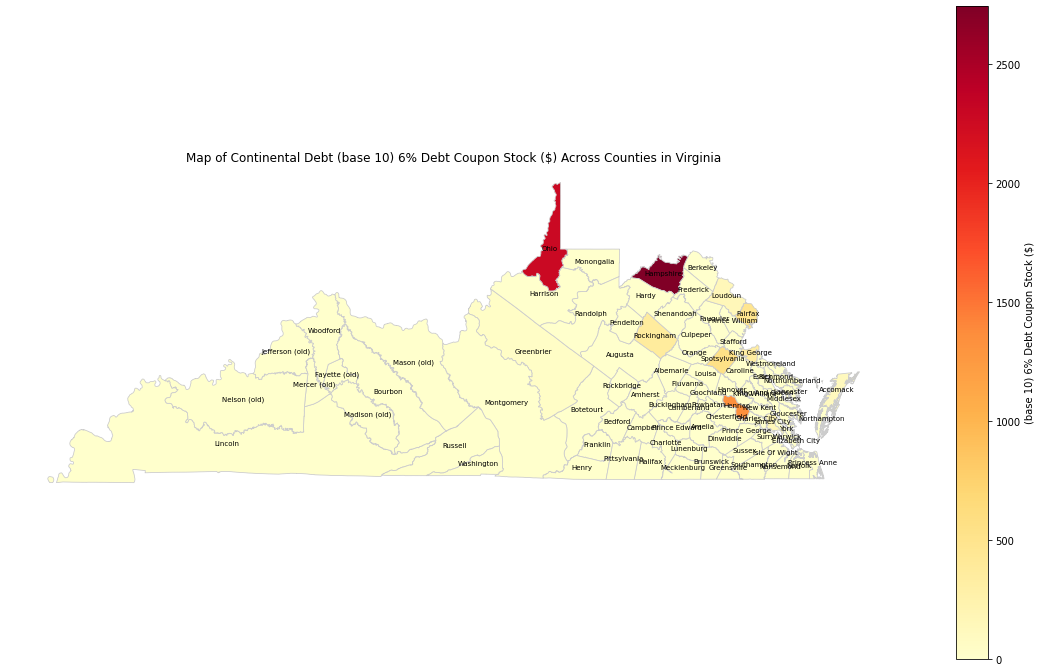

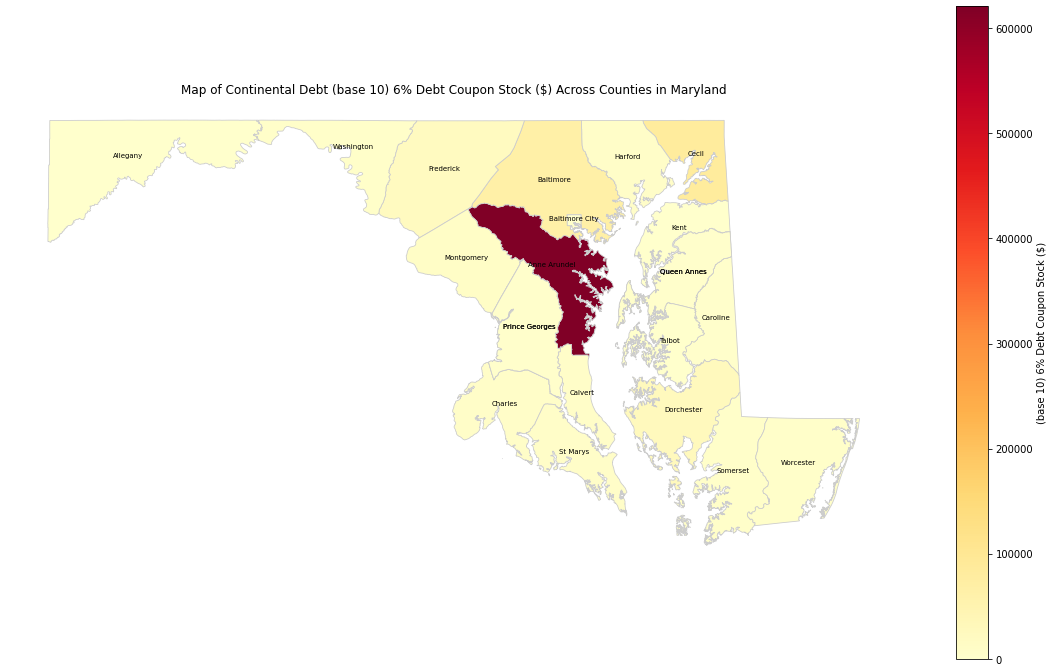

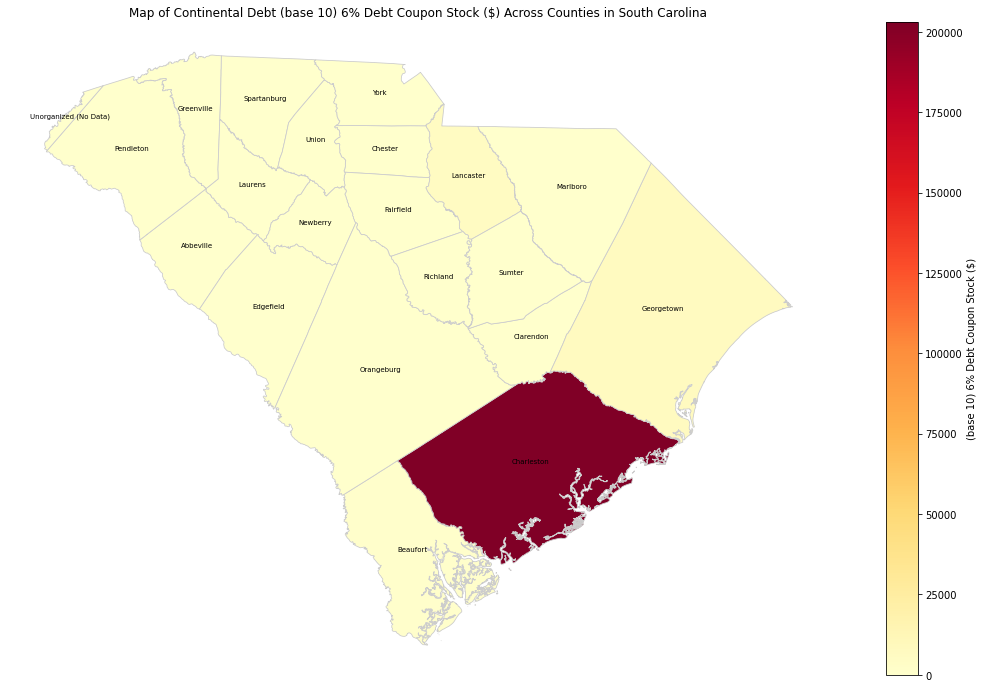

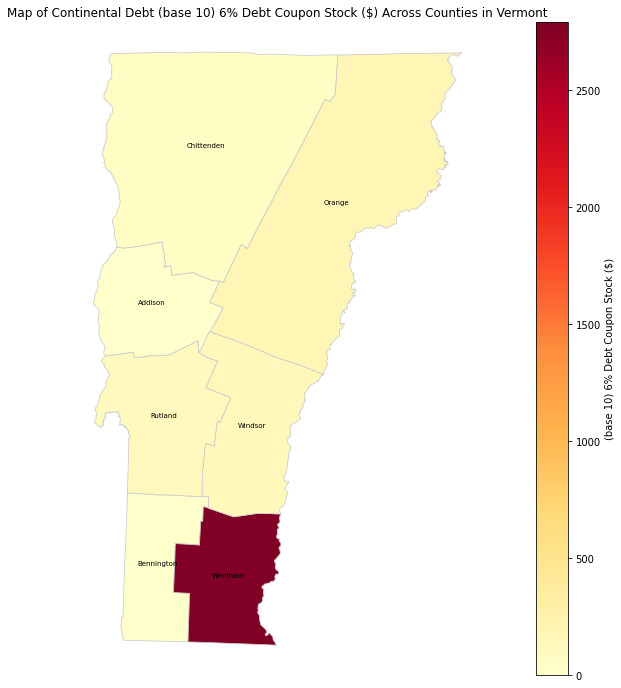

In [49]:
for state in statedict.values():
    plotState(merged, state)

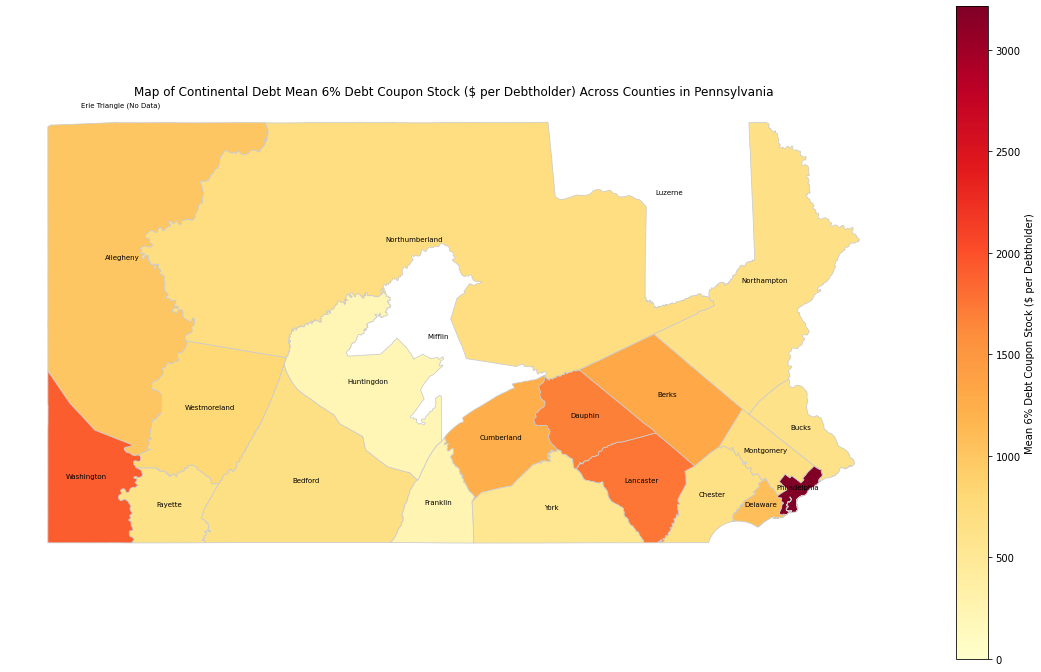

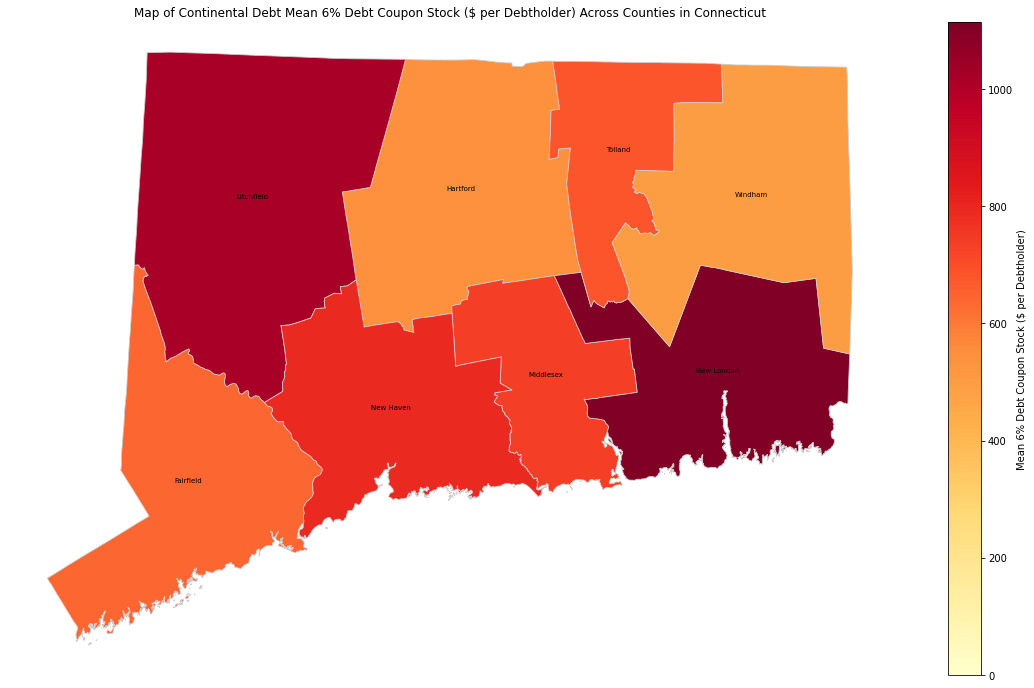

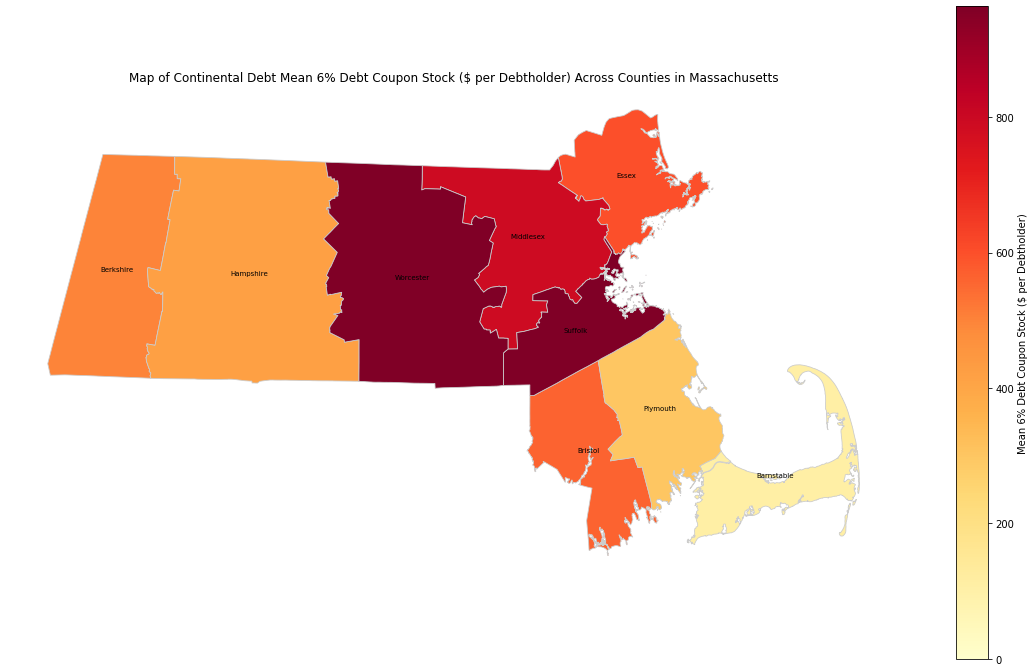

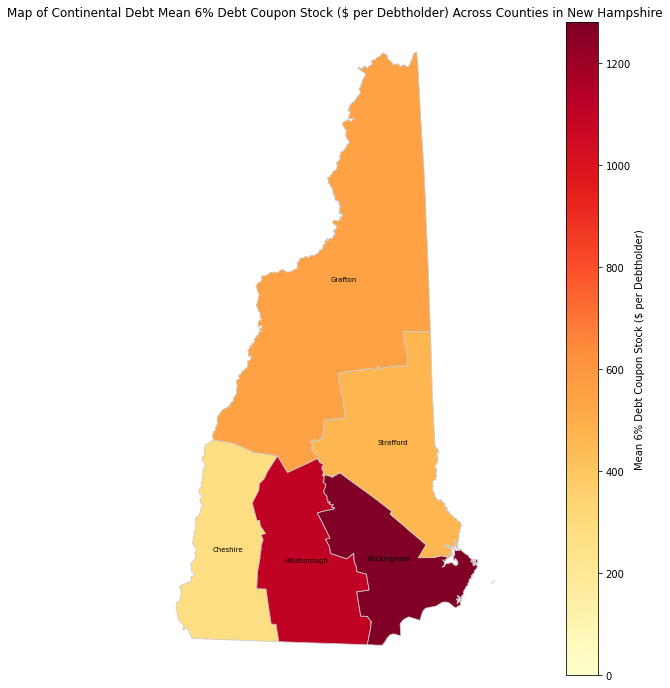

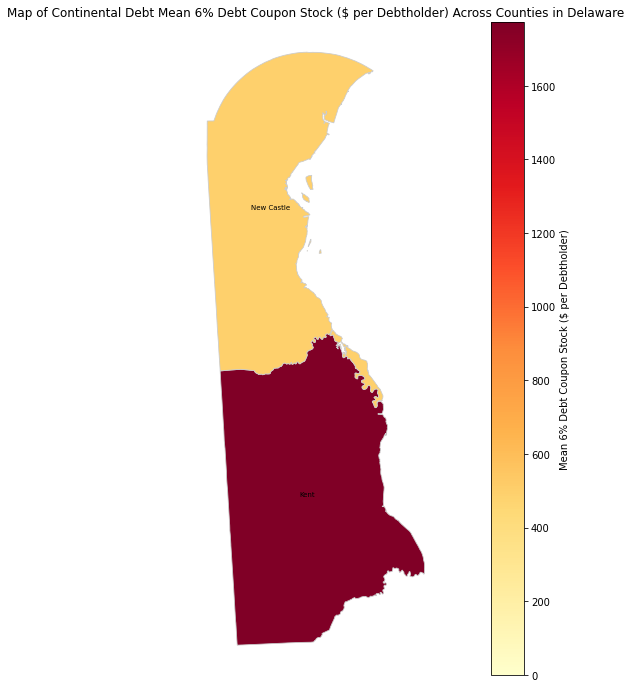

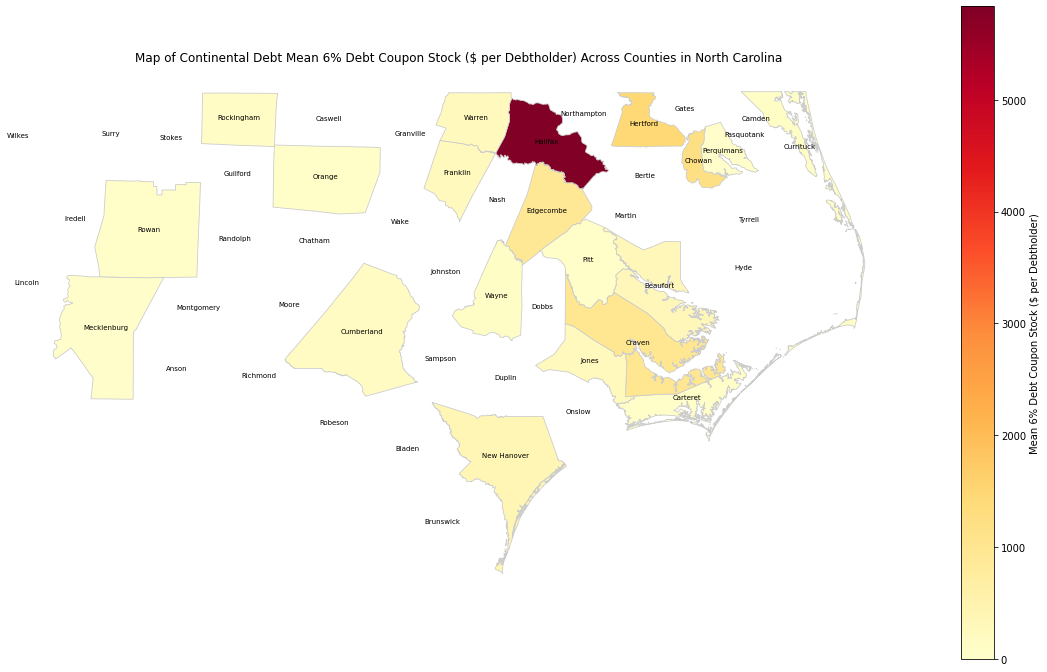

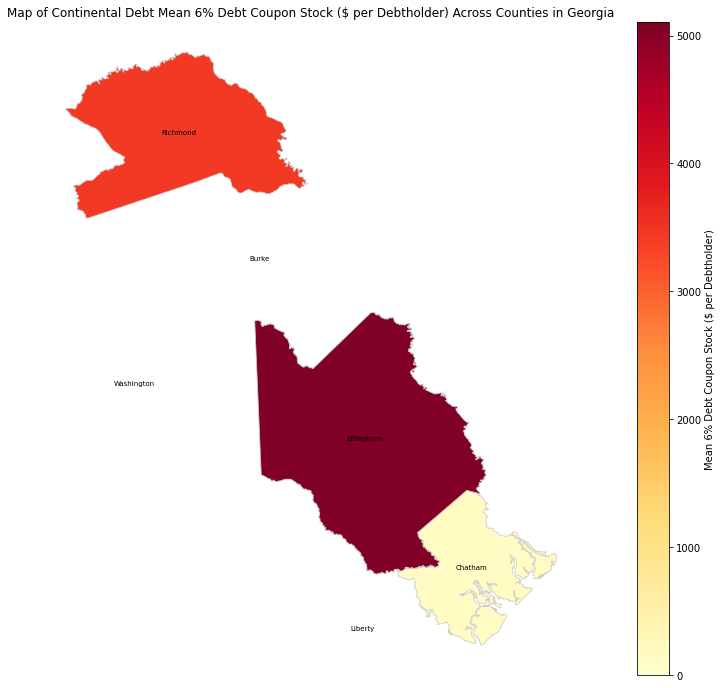

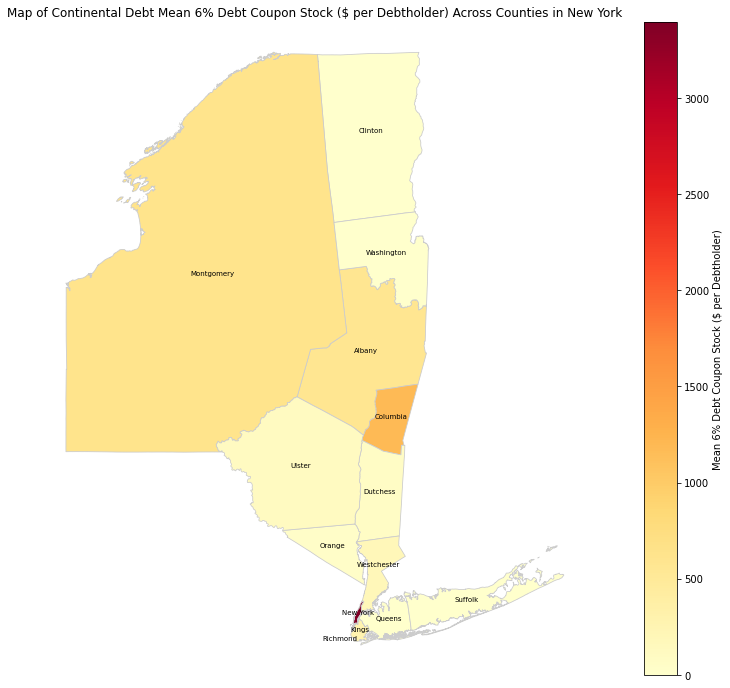

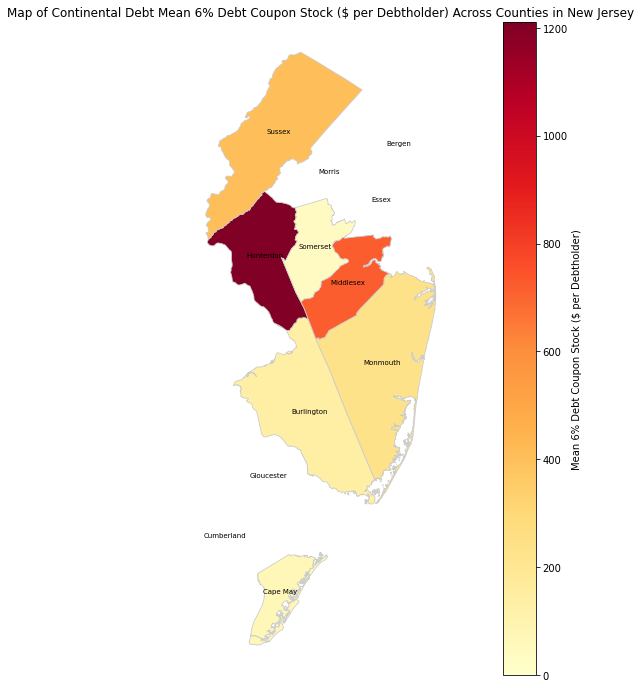

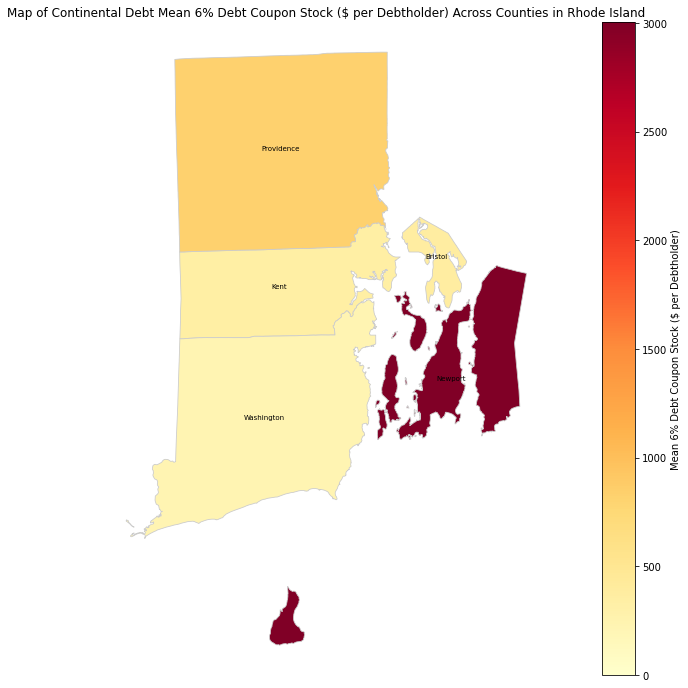

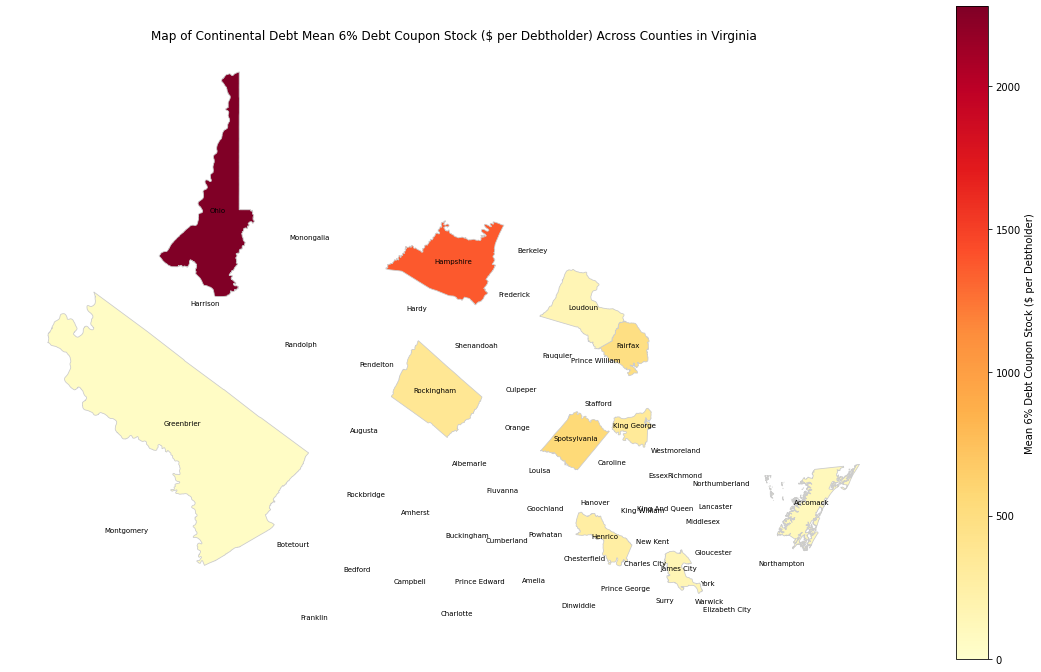

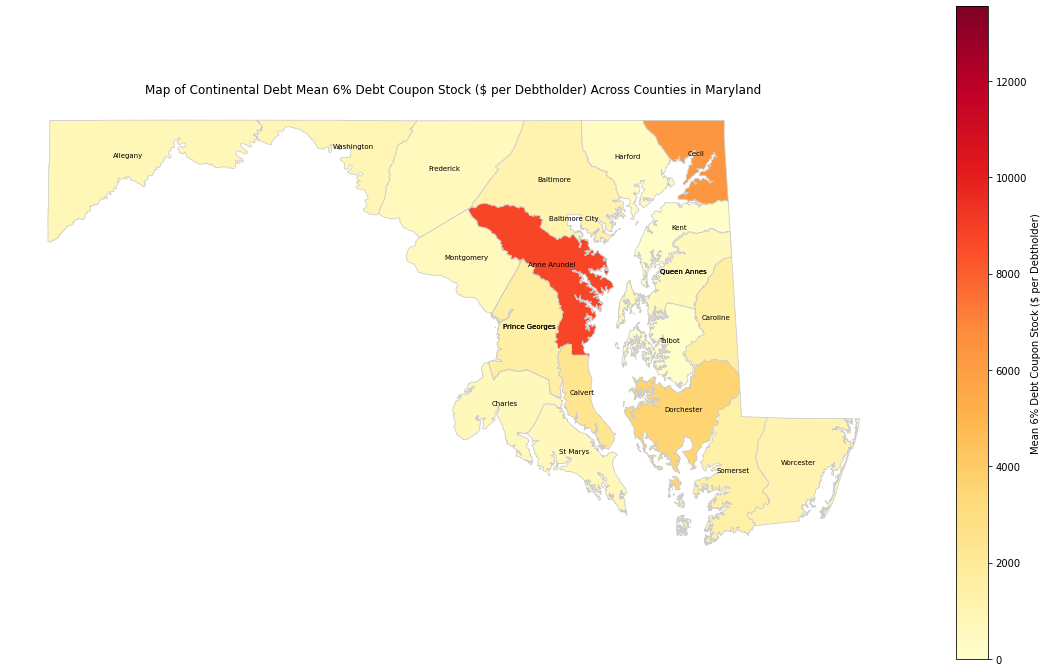

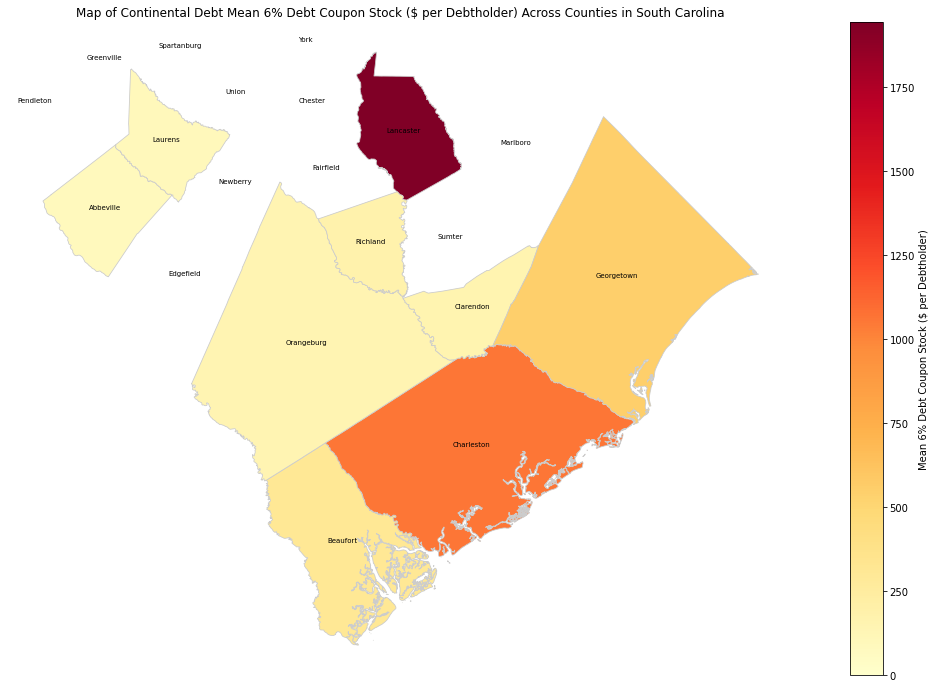

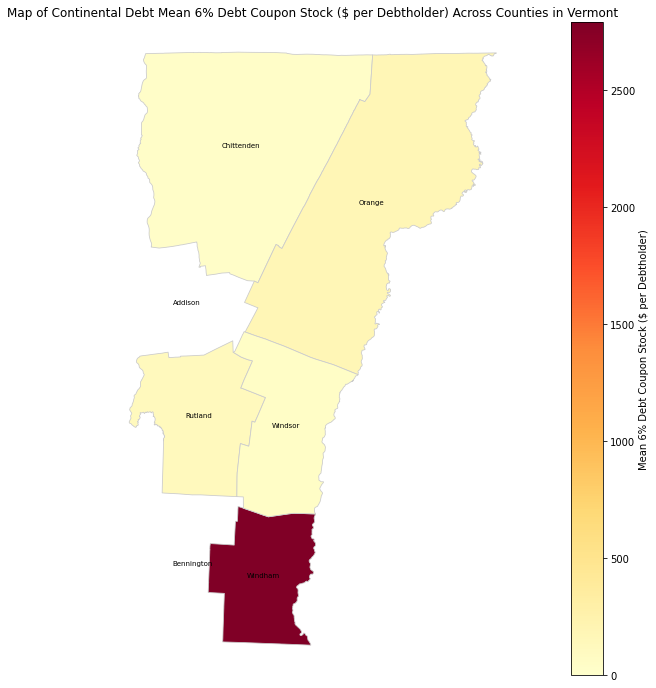

In [50]:
for state in statedict.values():
    plotState(merged, state, '6p_Total_avg')

In [65]:
def plotAllStates(merged, variable, log = "log10"):
    df = merged.copy()
    df[variable] = df[variable].fillna(0)
    fig, ax = plt.subplots(1, figsize=(20, 12))
    df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])
    if variable == '6p_Total':
        annot_df = df.groupby('state').agg({'centroid': min, variable: sum}).reset_index()
    if variable == '6p_Total_avg':
        annot_df = df.groupby('state').agg({'centroid': min, variable: 'mean'}).reset_index()

    annot_df = annot_df.sort_values('centroid')
    if log == "log10":
        df[variable] = df[variable].apply(lambda x: np.log10(x+1))
        annot_df[variable] = annot_df[variable].apply(lambda x: np.log10(x+1))
    if log == "nolog":
        pass
    vmin, vmax = 0.01, df[variable].max()
    print(vmax)
    cmap = plt.get_cmap('YlOrRd').copy()
    cmap.set_under('white')
    cmap.set_over('blue')
    if log == "log10":
        thresh = .85*vmax
    if log == "nolog":
        if variable == '6p_Total_avg':
            thresh = vmax/5
        else:
            thresh = vmax/8
    if variable == '6p_Total_avg':
        df[df[variable]>thresh].apply(lambda merged: ax.annotate(text=merged['county'] + " (" +  str(round(merged[variable], 2)) + ")", fontsize = 10, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)
    else:
        if log == "log10":
            df[df[variable]>thresh].apply(lambda merged: ax.annotate(text=merged['county'] + " (" +  str(round(merged[variable], 2)) + ")", fontsize = 10, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)
        else:
            df[df[variable]>thresh].apply(lambda merged: ax.annotate(text=merged['county'] + " (" +  str(round(merged[variable], 2)) + ", "+ str(round(merged[variable]/annot_df[variable].sum()*100, 1))+"%)", fontsize = 10, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)

    for i in range(annot_df.shape[0]):
        if variable == '6p_Total':
            if log == "nolog":
                annot_df.loc[[i]].apply(lambda merged: ax.annotate(text= merged['state']+ " Total: " + str(round(merged[variable], 2)) + " ("+str(round(merged[variable]/annot_df[variable].sum()*100, 1))+"%)", fontsize = 10, xy = (-87, 45-.8*i), ha = 'center'), axis=1)
        if variable == '6p_Total_avg':
            annot_df.loc[[i]].apply(lambda merged: ax.annotate(text= merged['state']+ " Average: " + str(round(merged[variable], 2)), fontsize = 10, xy = (-87, 45-.8*i), ha = 'center'), axis=1)

    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    if variable == "6p_Total":
        label = '6% Debt Coupon Stock ($)'
    if variable == "6p_Total_avg":
        label = 'Mean 6% Debt Coupon Stock ($ per Debtholder)'
    if variable == "debt_per_capita":
        label = '6% Debt per Capita Coupon Stock ($ per Individual)'
    if variable == "debt_per_white_male":
        label = '6% Debt per White Male Coupon Stock ($ per White Male)'
    cbar.set_label(label)

    df.plot(column=variable, cmap= cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax = vmax)

    ax.axis('off')
    ax.set_title("Map of Continental Debt {} Across All States".format(label))


    fig.savefig('../Results/maps/allstates/{}_{}_map.png'.format(variable, log), dpi = 200)

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_82626/1993411039.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])


1504212.05


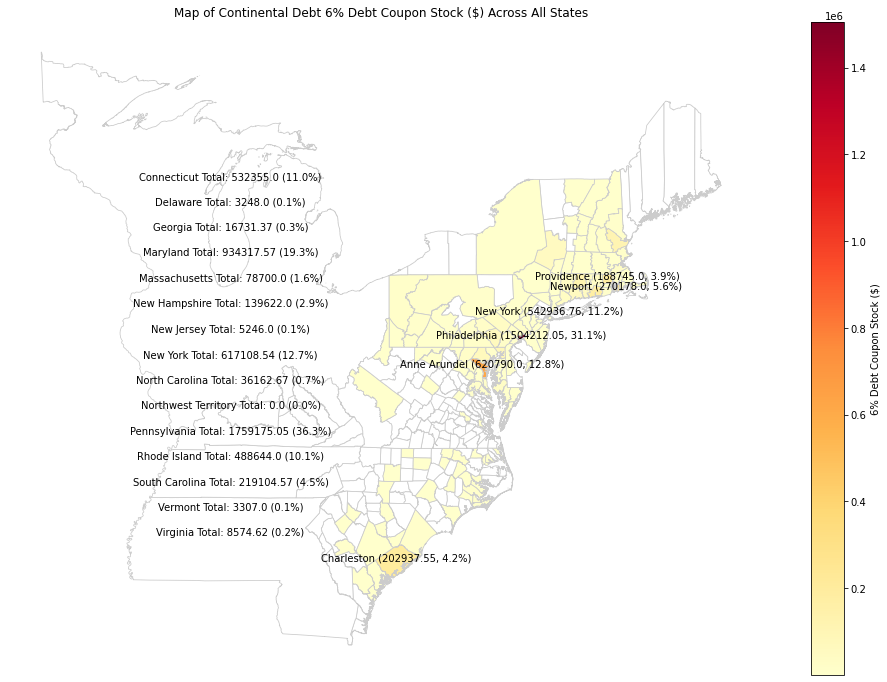

In [66]:
plotAllStates(merged, '6p_Total', log = "nolog")

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_82626/1993411039.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])


6.177309352137635


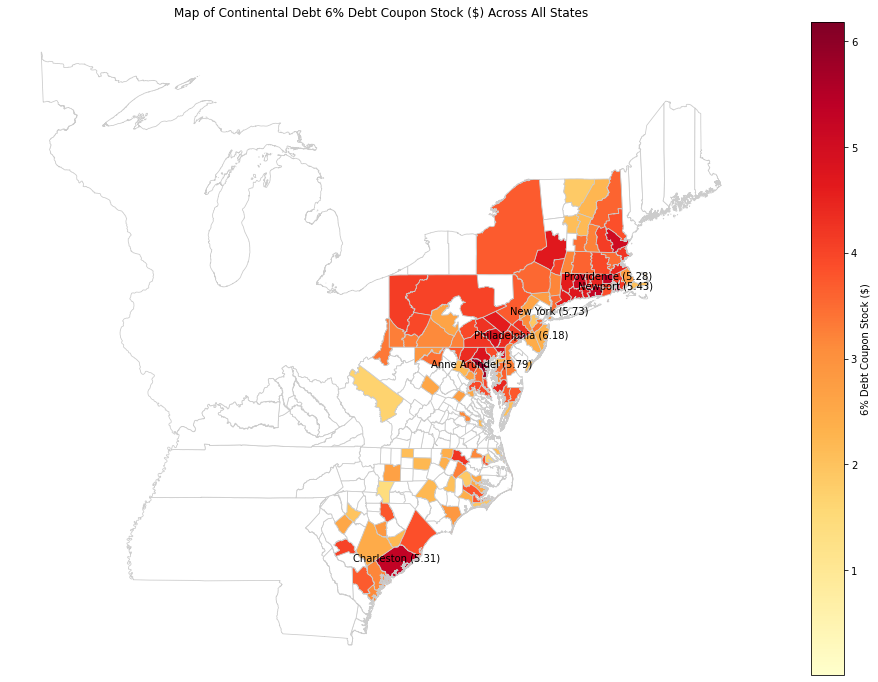

In [67]:
plotAllStates(merged, '6p_Total', log = "log10")

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_82626/1993411039.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])


13550.5


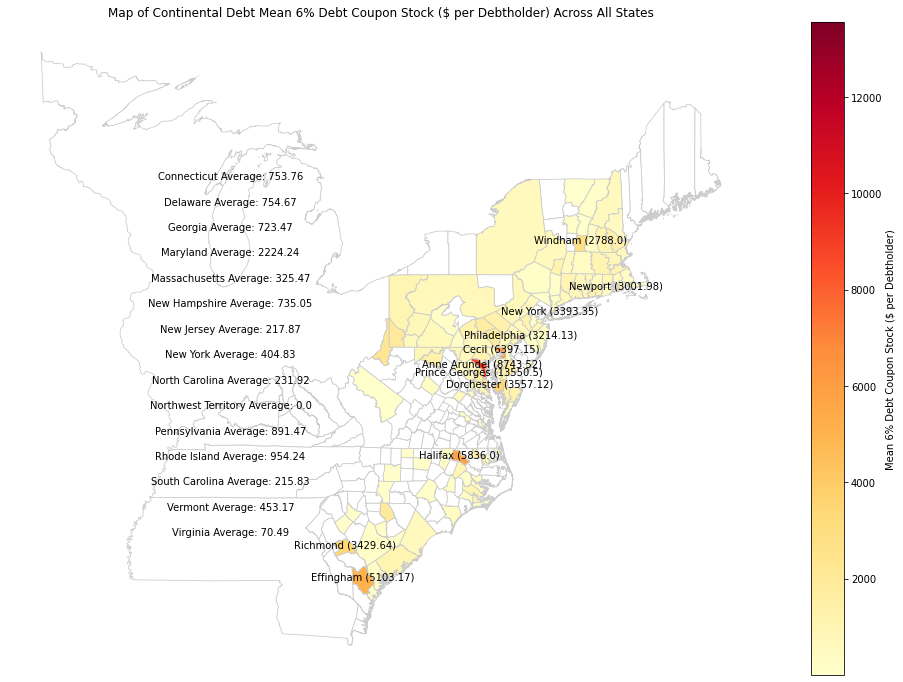

In [68]:
plotAllStates(merged, '6p_Total_avg', log = "nolog")